In [2]:
import xarray as xr
import numpy as np

In [3]:
zg = xr.open_dataset('/g/data/rt52/era5/pressure-levels/monthly-averaged/z/1959/z_era5_moda_pl_19590101-19590131.nc')['z']
ta = xr.open_dataset('/g/data/rt52/era5/pressure-levels/monthly-averaged/t/1959/t_era5_moda_pl_19590101-19590131.nc')['t']
hus = xr.open_dataset('/g/data/rt52/era5/pressure-levels/monthly-averaged/q/1959/q_era5_moda_pl_19590101-19590131.nc')['q']

ERROR 1: PROJ: proj_create_from_database: Open of /g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/share/proj failed


In [ ]:
da = ta + zg + hus
da

In [51]:
da.level

<xarray.DataArray 'level' (level: 37)>
array([   1,    2,    3,    5,    7,   10,   20,   30,   50,   70,  100,  125,
        150,  175,  200,  225,  250,  300,  350,  400,  450,  500,  550,  600,
        650,  700,  750,  775,  800,  825,  850,  875,  900,  925,  950,  975,
       1000], dtype=int32)
Coordinates:
  * level    (level) int32 1 2 3 5 7 10 20 30 ... 850 875 900 925 950 975 1000
Attributes:
    units:      millibars
    long_name:  pressure_level

In [52]:
da['level'] = da['level']*100
da = da.rename({'level': 'plev'})
da['plev']
da = da.sortby('plev')
da.plev

<xarray.DataArray 'plev' (plev: 37)>
array([   100,    200,    300,    500,    700,   1000,   2000,   3000,   5000,
         7000,  10000,  12500,  15000,  17500,  20000,  22500,  25000,  30000,
        35000,  40000,  45000,  50000,  55000,  60000,  65000,  70000,  75000,
        77500,  80000,  82500,  85000,  87500,  90000,  92500,  95000,  97500,
       100000], dtype=int32)
Coordinates:
  * plev     (plev) int32 100 200 300 500 700 ... 90000 92500 95000 97500 100000

In [ ]:
def regrid_vert(da, model = ''):                                                                                # does the same thing as scipy.interp1d, but quicker (can only be applied for models with 1D pressure coordinate)
    ''' Interpolate to common pressure levels (cloud fraction is dealt with separately)'''
    da['plev'] = da['plev'].round(0)                if model in ['ACCESS-ESM1-5', 'ACCESS-CM2'] else da['plev'] # plev coordinate is specified to a higher number of significant figures in these models
    p_new = np.array([100000, 92500, 85000, 70000, 60000, 50000, 40000, 30000, 25000, 20000, 15000, 10000, 7000, 5000, 3000, 2000, 1000, 500, 100])      

    import warnings
    warnings.filterwarnings("ignore", category=FutureWarning, module="xarray")
    da_p_new = da.interp(plev=p_new, method='linear', kwargs={'bounds_error':False, "fill_value": 0})    
    warnings.resetwarnings()
    return da_p_new

In [ ]:
da = regrid_vert(da)

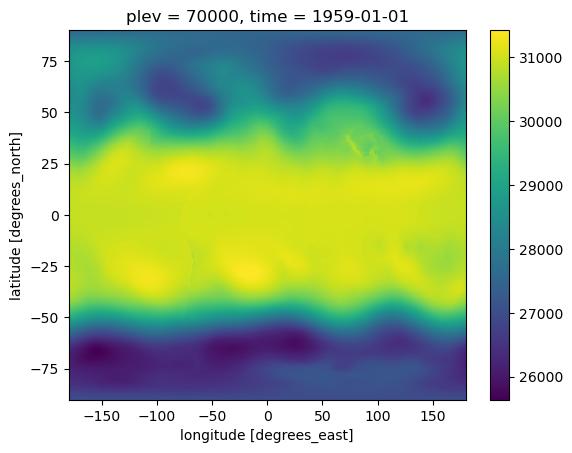

In [38]:
da.sel(plev = 700e2).plot()

In [21]:
def calc_vMean(da, dataset = '', plevs0 = 850e2, plevs1 = 0):       # free troposphere (as most values at 1000 hPa  and 925 hPa over land are NaN)                              
    plevs = slice(plevs0, plevs1)
    da = da.sel(plev=plevs)
    w = ~np.isnan(da) * da['plev']                                  # Where there are no values, exclude the associated pressure levels from the weights
    da = (da * w).sum(dim='plev') / w.sum(dim='plev') 
    return da

In [44]:
da_vMean = calc_vMean(da)
da_vMean

<xarray.DataArray (time: 1, latitude: 721, longitude: 1440)>
array([[[47236.96451436, 47236.96451436, 47236.96451436, ...,
         47236.96451436, 47236.96451436, 47236.96451436],
        [47260.99768678, 47261.09334522, 47261.14726824, ...,
         47259.49231829, 47259.95131645, 47260.45055826],
        [47286.2442972 , 47286.26710269, 47286.30536606, ...,
         47285.5109898 , 47286.24048661, 47286.2442972 ],
        ...,
        [47497.77065091, 47497.77062384, 47497.77022035, ...,
         47497.77190569, 47497.77154155, 47497.77115774],
        [47507.96635441, 47507.96619694, 47507.96599519, ...,
         47507.96726966, 47507.96706791, 47507.96663981],
        [47509.22925845, 47509.22925845, 47509.22925845, ...,
         47509.22925845, 47509.22925845, 47509.22925845]]])
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1959-01-01

In [35]:
zg = get_era5_monthly('z')
zg

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/esmpy/__init__.py:106: DeprecationWarning: Implicit None on return values is deprecated and will raise KeyErrors.
  __author__ = msg["Author"]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/esmpy/__init__.py:107: DeprecationWarning: Implicit None on return values is deprecated and will raise KeyErrors.
  __homepage__ = msg["Home-page"]
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/esmpy/__init__.py:108: DeprecationWarning: Implicit None on return values is deprecated and will raise KeyErrors.
  __obsoletes__ = msg["obsoletes"]


ModuleNotFoundError: No module named 'ESMF'

In [10]:
ta = get_era5_monthly('t')
ta

In [11]:
hus = get_era5_monthly('q')
hus

In [15]:
da = ta['t'] + zg['z'] + hus['q']
da

<xarray.DataArray (time: 288, plev: 19, lat: 241, lon: 1440)>
dask.array<add, shape=(288, 19, 241, 1440), dtype=float32, chunksize=(1, 19, 241, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * lat      (lat) float32 -30.0 -29.75 -29.5 -29.25 ... 29.25 29.5 29.75 30.0
  * time     (time) datetime64[ns] 1998-01-01 1998-02-01 ... 2021-12-01
  * plev     (plev) int64 100000 92500 85000 70000 60000 ... 2000 1000 500 100

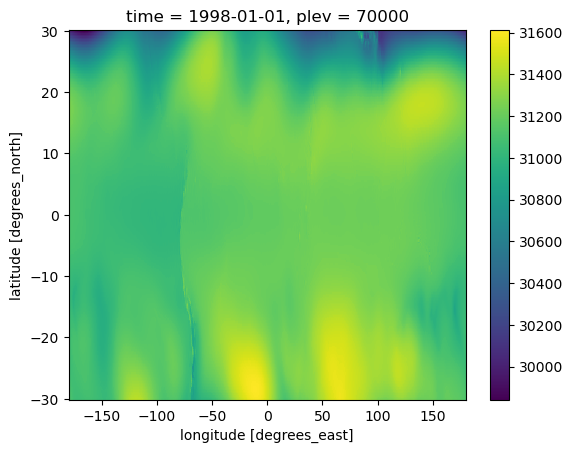

In [16]:
da.isel(time=0).sel(plev = 700e2).plot()

In [23]:
da_vMean = calc_vMean(da)
da_vMean

<xarray.DataArray (time: 288, lat: 241, lon: 1440)>
dask.array<truediv, shape=(288, 241, 1440), dtype=float64, chunksize=(1, 241, 1440), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * lat      (lat) float32 -30.0 -29.75 -29.5 -29.25 ... 29.25 29.5 29.75 30.0
  * time     (time) datetime64[ns] 1998-01-01 1998-02-01 ... 2021-12-01

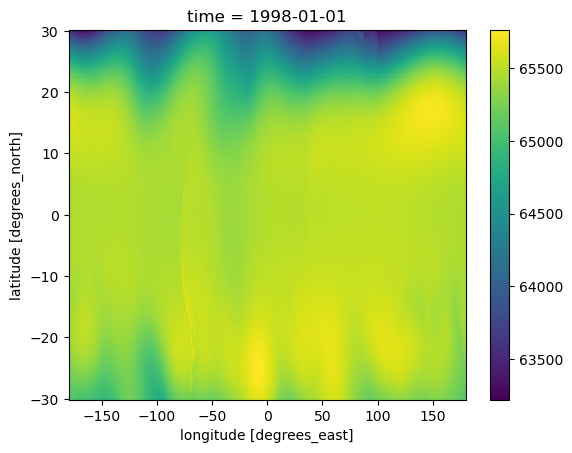

In [24]:
da_vMean.isel(time=0).plot()